In [1]:
import pandas as pd
import torch
import numpy as np
#from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import os,random
import torchvision.transforms as T
import csv
import cv2
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from scipy.fft import fft2, ifft2, fftshift

# input valid data

In [8]:
import os
import random
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import cv2

# Custom transform for adding Gaussian noise
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return f'{self.__class__.__name__}(mean={self.mean}, std={self.std})'

# Data augmentation transform
augment_transform = transforms.Compose([
    transforms.Resize(1200),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    AddGaussianNoise(mean=0.0, std=0.1),
    transforms.Normalize((0.5,), (0.5,))
])

# Original transform
original_transform = transforms.Compose([
    transforms.Resize(1200),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def generate_augmented_dataset(dir, csv_file, augment_times=5):
    pathDir = os.listdir(dir)
    filenumber = len(pathDir)
    sample = random.sample(pathDir, filenumber)
    
    file = pd.read_csv(csv_file)
    file = np.array(file)
    labels = []
    img_data = []

    def classify_force(force):
        return min((force // 10), 23)

    for file_name in sample:
        if file_name != "Thumbs.db":
            if int(file_name[-9:-4]) > 2097 and int(file_name[-9:-4]) < 3597:
                img_dir = os.path.join(dir, file_name)
                img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
                ref_img = cv2.imread('database/202404-inkan/output-resize/DSC02098.JPG', cv2.IMREAD_GRAYSCALE)
                img1 = cv2.absdiff(img, ref_img)
                img_pil = Image.fromarray(img1)

                for _ in range(augment_times):
                    augmented_img = augment_transform(img_pil)
                    img_data.append(augmented_img)

                original_img = original_transform(img_pil)
                img_data.append(original_img)

                for item in file:
                    sh = item[1]
                    if file_name[-9:-4] == sh[-9:-4]:
                        force = item[0]
                        label = classify_force(force)
                        labels.extend([label] * (augment_times + 1))
    
    labels = torch.tensor(labels, dtype=torch.long)
    return img_data, labels

class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.imgs = list(zip(data, labels))

    def __getitem__(self, index):
        fn, label = self.imgs[index]
        return fn, label

    def __len__(self):
        return len(self.imgs)

In [9]:
validdir = 'database/202404-inkan/valid-or/'
csv_file = './label/AI-bolt-color-202404-inkan.csv'

valid_rdata, valid_label = generate_augmented_dataset(validdir, csv_file, augment_times=0)
valid_data = MyDataset(valid_rdata, valid_label)
valid_loader = DataLoader(dataset=valid_data, batch_size=1, shuffle=True)


305 305
torch.Size([1, 1, 1200, 1200])
tensor([8])
torch.Size([1])


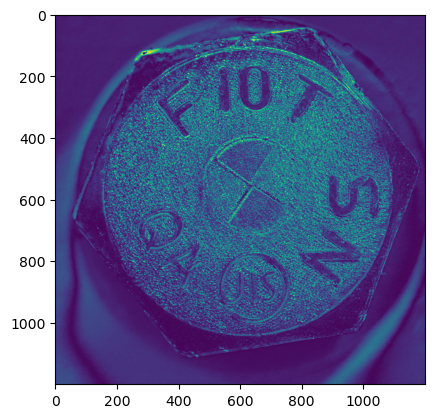

In [10]:
print(len(valid_rdata), len(valid_label))
dataiter=iter(valid_loader)
images, labels = dataiter.__next__()
print(images.shape)
print(labels)
print(labels.shape)
topic = T.ToPILImage()
imm1 = topic(images[0])
vimg, vlabels = dataiter.__next__()
plt.imshow(topic(vimg[0]))

# -pa model

In [11]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid())

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y
    
class Bottleneck(nn.Module):
    """
    __init__
        in_channel：残差块输入通道数
        out_channel：残差块输出通道数
        stride：卷积步长
        downsample：在_make_layer函数中赋值，用于控制shortcut图片下采样 H/2 W/2
    """
    expansion = 4   # 残差块第3个卷积层的通道膨胀倍率
    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1, stride=1, bias=False)   # H,W不变。C: in_channel -> out_channel
        self.bn1 = nn.BatchNorm2d(num_features=out_channel)
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=stride, bias=False, padding=1)  # H/2，W/2。C不变
        self.bn2 = nn.BatchNorm2d(num_features=out_channel)
        self.conv3 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel*self.expansion, kernel_size=1, stride=1, bias=False)   # H,W不变。C: out_channel -> 4*out_channel
        self.bn3 = nn.BatchNorm2d(num_features=out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        # Add SEBlock
        self.seblock = SEBlock(out_channel*self.expansion)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x    # 将原始输入暂存为shortcut的输出
        if self.downsample is not None:
            identity = self.downsample(x)   # 如果需要下采样，那么shortcut后:H/2，W/2。C: out_channel -> 4*out_channel(见ResNet中的downsample实现)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        #Apply SEBlock
        out = self.seblock(out)

        out += identity     # 残差连接0 n
        out = self.relu(out)

        return out


class ModResdic(nn.Module):
    """
    __init__
        block: 堆叠的基本模块
        block_num: 基本模块堆叠个数,是一个list,对于resnet50=[3,4,6,3]
        num_classes: 全连接之后的分类特征维度

    _make_layer
        block: 堆叠的基本模块
        channel: 每个stage中堆叠模块的第一个卷积的卷积核个数，对resnet50分别是:64,128,256,512
        block_num: 当期stage堆叠block个数
        stride: 默认卷积步长
    """
    def __init__(self, block, block_num, num_classes, num_attention_heads=4):
        super(ModResdic, self).__init__()
        self.in_channel = 64    # conv1的输出维度
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=self.in_channel, kernel_size=7, stride=2, padding=3, bias=False)     # H/2,W/2。C:3->64
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.activation = nn.LeakyReLU(negative_slope=0.01)
        self.sigmoid = nn.Sigmoid()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)     # H/2,W/2。C不变
        self.layer1 = self._make_layer(block=block, channel=64, block_num=block_num[0], stride=1)   # H,W不变。downsample控制的shortcut，out_channel=64x4=256
        self.layer2 = self._make_layer(block=block, channel=128, block_num=block_num[1], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=128x4=512
        self.layer3 = self._make_layer(block=block, channel=256, block_num=block_num[2], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=256x4=1024
        self.layer4 = self._make_layer(block=block, channel=512, block_num=block_num[3], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=512x4=2048

        # 添加自注意力层
        self.self_attention = nn.MultiheadAttention(embed_dim=2048, num_heads=num_attention_heads)

        # Add SEBlocks after each residual block in the feature extraction layers
        self.seblock1 = SEBlock(64 * block.expansion)
        self.seblock2 = SEBlock(128 * block.expansion)
        self.seblock3 = SEBlock(256 * block.expansion)
        self.seblock4 = SEBlock(512 * block.expansion)

        self.fusion4 = MultiScaleFusion(1024 * block.expansion)
        self.fusion3 = MultiScaleFusion(512 * block.expansion)
        self.fusion2 = MultiScaleFusion(256 * block.expansion)
        self.fusion1 = MultiScaleFusion(128 * block.expansion)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))  # 将每张特征图大小->(1,1)，则经过池化后的输出维度=通道数
        self.fc1 = nn.Linear(in_features=512*block.expansion, out_features=1024) #in=2048,out=1024
        self.dropout = nn.Dropout(0.8) #dropout rate
        self.fc2 = nn.Linear(in_features=2048, out_features=1024) #in=1024, out=1
        self.fc3 = nn.Linear(in_features=1024, out_features=num_classes) #in=512, out=1
        #self.fc4 = nn.Linear(in_features=64, out_features=num_classes) #in=128, out=1

        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Upsampling layers for feature fusion
        self.upsample = lambda x: nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=None).to(x.device)
        #self.upsample = nn.functional.interpolate(scale_factor=2, mode='bilinear', align_corners=True)
        
        for m in self.modules():    # 权重初始化
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None   # 用于控制shorcut路的
        if stride != 1 or self.in_channel != channel*block.expansion:   # 对resnet50：conv2中特征图尺寸H,W不需要下采样/2，但是通道数x4，因此shortcut通道数也需要x4。对其余conv3,4,5，既要特征图尺寸H,W/2，又要shortcut维度x4
            downsample = nn.Sequential(
                nn.Conv2d(in_channels=self.in_channel, out_channels=channel*block.expansion, kernel_size=1, stride=stride, bias=False), # out_channels决定输出通道数x4，stride决定特征图尺寸H,W/2
                nn.BatchNorm2d(num_features=channel*block.expansion))

        layers = []  # 每一个convi_x的结构保存在一个layers列表中，i={2,3,4,5}
        layers.append(block(in_channel=self.in_channel, out_channel=channel, downsample=downsample, stride=stride)) # 定义convi_x中的第一个残差块，只有第一个需要设置downsample和stride
        self.in_channel = channel*block.expansion   # 在下一次调用_make_layer函数的时候，self.in_channel已经x4

        for _ in range(1, block_num):  # 通过循环堆叠其余残差块(堆叠了剩余的block_num-1个)
            layers.append(block(in_channel=self.in_channel, out_channel=channel))

        return nn.Sequential(*layers)   # '*'的作用是将list转换为非关键字参数传入

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x1 = self.fusion1(x1)
        x1 = self.seblock1(x1)
        x2 = self.layer2(x1)
        #x2 = self.seblock2(x2)
        #x2 = self.fusion2(x2)
        x3 = self.layer3(x2)
        #x3 = self.seblock3(x3)
        #x3 = self.fusion3(x3)
        x4 = self.layer4(x3)
        x4 = self.seblock4(x4)
        x4 = self.fusion4(x4)

        x = self.avgpool(x4)
        x = torch.flatten(x, 1)

        # 添加自注意力层
        x, _ = self.self_attention(x.unsqueeze(0), x.unsqueeze(0), x.unsqueeze(0))
        x = x.squeeze(0)  # 移除添加的维度以适应全连接层的输入要求

        #x = x.unsqueeze(0)  # 添加一个维度以适应自注意力层的输入要求
        #x, _ = self.self_attention(x, x, x)
        
        #x = self.relu(self.fc1(x))
        #x = self.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)

        return x

class MultiScaleFusion(nn.Module):
    def __init__(self,out_channels):
        super(MultiScaleFusion, self).__init__()
        self.conv1 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=5, stride=1, padding=2)
        # 定义融合的卷积层
        self.fusion_conv = nn.Conv2d(4*out_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        out = torch.cat([x,x1, x2, x3], dim=1)
        # 对融合的特征图进行卷积操作
        out = self.fusion_conv(out)
        out = self.bn(out)
        out = self.relu(out)
        return out
    
class ModResv2(nn.Module):
    """
    __init__
        block: 堆叠的基本模块
        block_num: 基本模块堆叠个数,是一个list,对于resnet50=[3,4,6,3]
        num_classes: 全连接之后的分类特征维度

    _make_layer
        block: 堆叠的基本模块
        channel: 每个stage中堆叠模块的第一个卷积的卷积核个数，对resnet50分别是:64,128,256,512
        block_num: 当期stage堆叠block个数
        stride: 默认卷积步长
    """
    def __init__(self, block, block_num, num_classes, num_attention_heads=4):
        super(ModResv2, self).__init__()
        self.in_channel = 64    # conv1的输出维度

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.in_channel, kernel_size=7, stride=2, padding=3, bias=False)     # H/2,W/2。C:3->64
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.activation = nn.LeakyReLU(negative_slope=0.01)
        self.sigmoid = nn.Sigmoid()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)     # H/2,W/2。C不变
        self.layer1 = self._make_layer(block=block, channel=64, block_num=block_num[0], stride=1)   # H,W不变。downsample控制的shortcut，out_channel=64x4=256
        self.layer2 = self._make_layer(block=block, channel=128, block_num=block_num[1], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=128x4=512
        self.layer3 = self._make_layer(block=block, channel=256, block_num=block_num[2], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=256x4=1024
        self.layer4 = self._make_layer(block=block, channel=512, block_num=block_num[3], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=512x4=2048
        
        self.self_attention = nn.MultiheadAttention(embed_dim=2048, num_heads=num_attention_heads)

        # Add SEBlocks after each residual block in the feature extraction layers
        self.seblock1 = SEBlock(64 * block.expansion)
        self.seblock2 = SEBlock(128 * block.expansion)
        self.seblock3 = SEBlock(256 * block.expansion)
        self.seblock4 = SEBlock(512 * block.expansion)

        self.fusion4 = MultiScaleFusion(512 * block.expansion)
        #self.fusion3 = MultiScaleFusion(256 * block.expansion)
        #self.fusion2 = MultiScaleFusion(128 * block.expansion)
        self.fusion1 = MultiScaleFusion(64 * block.expansion)


        self.avgpool = nn.AdaptiveAvgPool2d((1,1))  # 将每张特征图大小->(1,1)，则经过池化后的输出维度=通道数
        self.fc1 = nn.Linear(in_features=512*block.expansion, out_features=1024) #in=2048,out=1024
        self.dropout = nn.Dropout(0.6) #dropout rate
        self.fc2 = nn.Linear(in_features=1024, out_features=num_classes) #in=1024, out=1
        #self.fc3 = nn.Linear(in_features=512, out_features=num_classes) #in=512, out=1
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Upsampling layers for feature fusion
        self.upsample = lambda x: nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=None).to(x.device)
        #self.upsample = nn.functional.interpolate(scale_factor=2, mode='bilinear', align_corners=True)
        
        for m in self.modules():    # 权重初始化
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None   # 用于控制shorcut路的
        if stride != 1 or self.in_channel != channel*block.expansion:   # 对resnet50：conv2中特征图尺寸H,W不需要下采样/2，但是通道数x4，因此shortcut通道数也需要x4。对其余conv3,4,5，既要特征图尺寸H,W/2，又要shortcut维度x4
            downsample = nn.Sequential(
                nn.Conv2d(in_channels=self.in_channel, out_channels=channel*block.expansion, kernel_size=1, stride=stride, bias=False), # out_channels决定输出通道数x4，stride决定特征图尺寸H,W/2
                nn.BatchNorm2d(num_features=channel*block.expansion))

        layers = []  # 每一个convi_x的结构保存在一个layers列表中，i={2,3,4,5}
        layers.append(block(in_channel=self.in_channel, out_channel=channel, downsample=downsample, stride=stride)) # 定义convi_x中的第一个残差块，只有第一个需要设置downsample和stride
        self.in_channel = channel*block.expansion   # 在下一次调用_make_layer函数的时候，self.in_channel已经x4

        for _ in range(1, block_num):  # 通过循环堆叠其余残差块(堆叠了剩余的block_num-1个)
            layers.append(block(in_channel=self.in_channel, out_channel=channel))

        return nn.Sequential(*layers)   # '*'的作用是将list转换为非关键字参数传入

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x1 = self.seblock1(x1)
        x1 = self.fusion1(x1)
        x2 = self.layer2(x1)
        x2 = self.seblock2(x2)
        x3 = self.layer3(x2)
        x3 = self.seblock3(x3)
        x4 = self.layer4(x3)
        x4 = self.seblock4(x4)
        x4 = self.fusion4(x4)

        x = self.avgpool(x4)
        x = torch.flatten(x, 1)

        # 添加自注意力层
        x, _ = self.self_attention(x.unsqueeze(0), x.unsqueeze(0), x.unsqueeze(0))
        x = x.squeeze(0) 

        #x = self.activation(self.fc1(x))
        x = self.dropout(x)
        #x = self.activation(self.fc2(x))
        x = self.fc(x)

        return x

In [12]:
model= ModResv2(block=Bottleneck, block_num=[3,4,6,3],num_classes=24)

# 加载模型权重
model_path = 'best_model.pth'
model.load_state_dict(torch.load(model_path))

# 设置模型为评估模式
model.eval()

ModResv2(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (seblock): SEB

In [13]:
def valid(model, device, valid_loader, classes):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # 计算各项指标
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted', labels=np.arange(24))
    recall = recall_score(all_labels, all_predictions, average='weighted', labels=np.arange(24))
    f1 = f1_score(all_labels, all_predictions, average='weighted', labels=np.arange(24))
    conf_matrix = confusion_matrix(all_labels, all_predictions, labels=np.arange(24))
    class_report = classification_report(all_labels, all_predictions, target_names=classes, labels=np.arange(24))

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('\nClassification Report:\n', class_report)

    # 绘制混淆矩阵
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1, conf_matrix, class_report

In [17]:
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    valid(model, device, valid_loader, 24)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same